----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                [-1, 1, 64]          50,176
              ReLU-2                [-1, 1, 64]               0
            Linear-3                [-1, 1, 64]           4,096
              ReLU-4                [-1, 1, 64]               0
            Linear-5                [-1, 1, 64]           4,096
              ReLU-6                [-1, 1, 64]               0
            Linear-7                [-1, 1, 64]           4,096
              ReLU-8                [-1, 1, 64]               0
            Linear-9                [-1, 1, 10]             640
Total params: 63,104
Trainable params: 63,104
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.24
Estimated Total Size (MB): 0.25
---------------------------------------------

/opt/homebrew/lib/python3.11/site-packages/torch/autograd/graph.py:690: UserWarning: Using backward() with create_graph=True will create a reference cycle between the parameter and its gradient which can cause a memory leak. We recommend using autograd.grad when creating the graph to avoid this. If you have to use this function, make sure to reset the .grad fields of your parameters to None after use to break the cycle and avoid the leak. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/autograd/engine.cpp:1183.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Finished Training task0
Finished Training task1
Finished Training task2
Finished Training task3


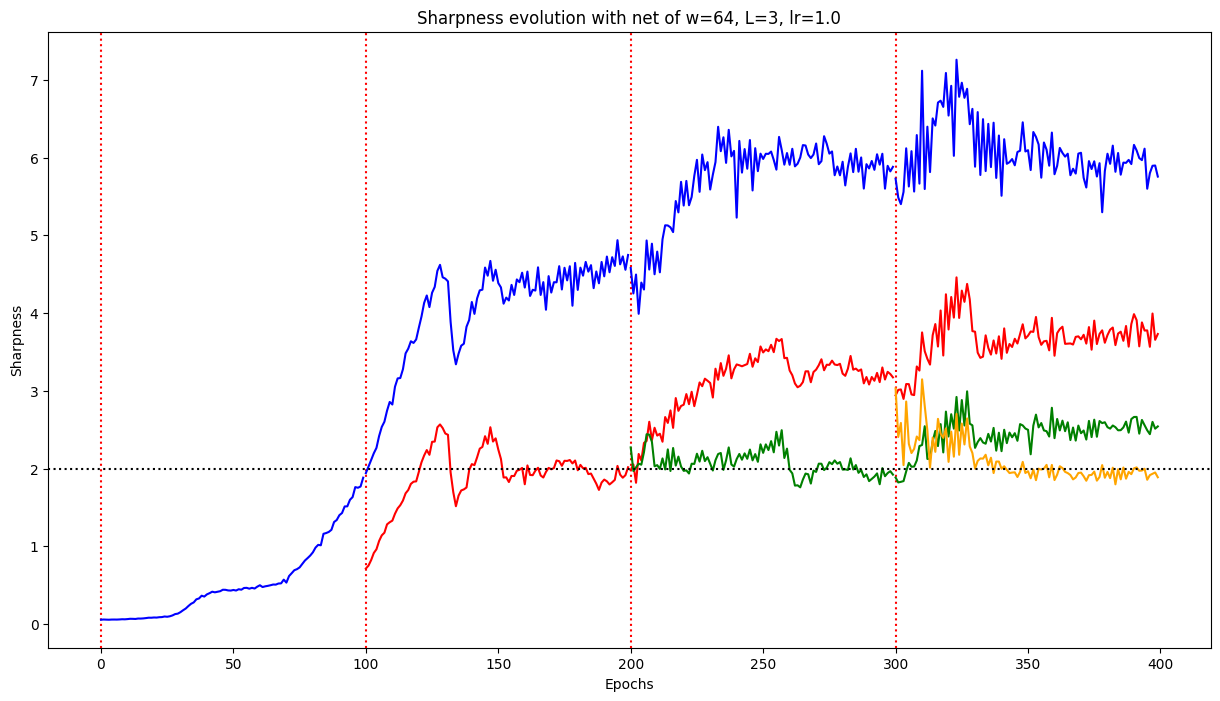

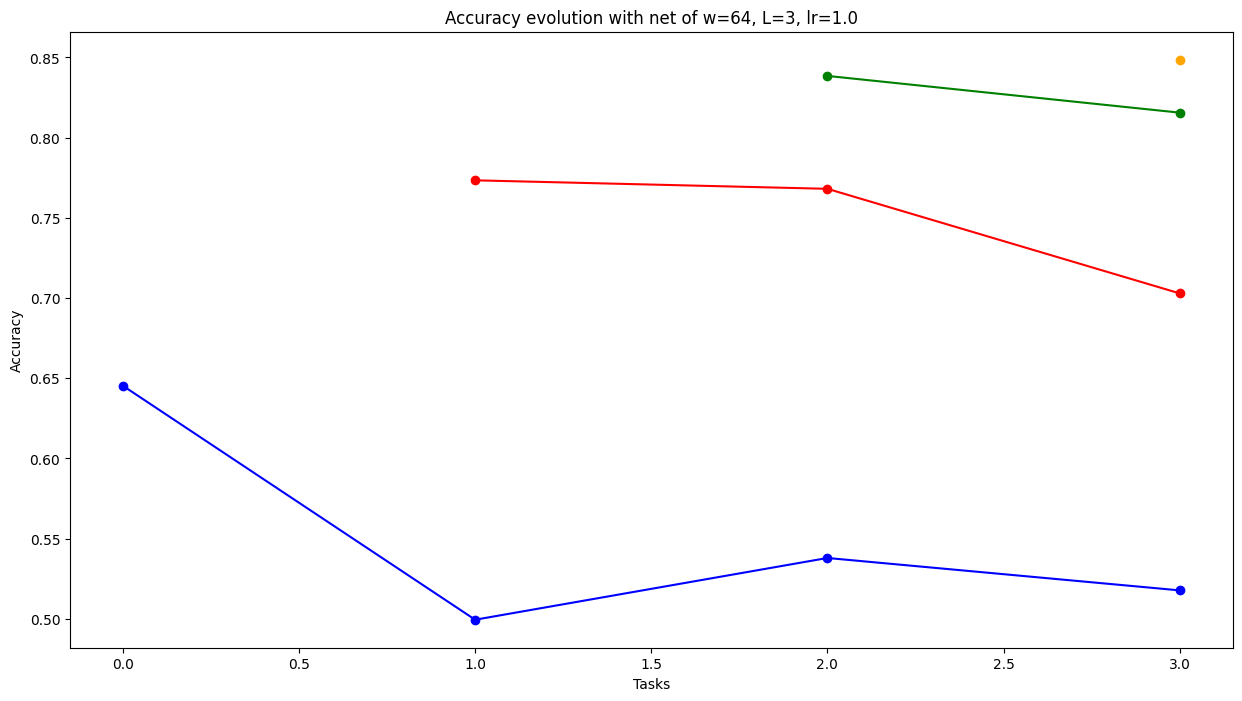

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                [-1, 1, 64]          50,176
              ReLU-2                [-1, 1, 64]               0
            Linear-3                [-1, 1, 64]           4,096
              ReLU-4                [-1, 1, 64]               0
            Linear-5                [-1, 1, 64]           4,096
              ReLU-6                [-1, 1, 64]               0
            Linear-7                [-1, 1, 64]           4,096
              ReLU-8                [-1, 1, 64]               0
            Linear-9                [-1, 1, 10]             640
Total params: 63,104
Trainable params: 63,104
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.24
Estimated Total Size (MB): 0.25
---------------------------------------------

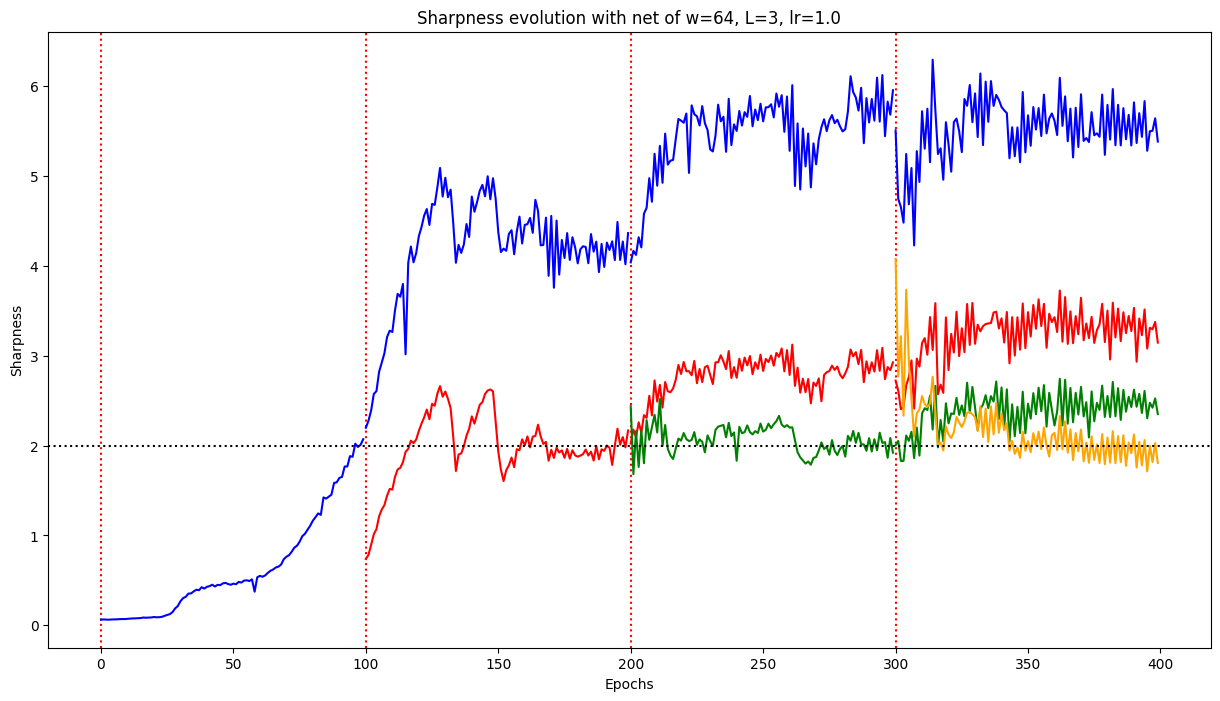

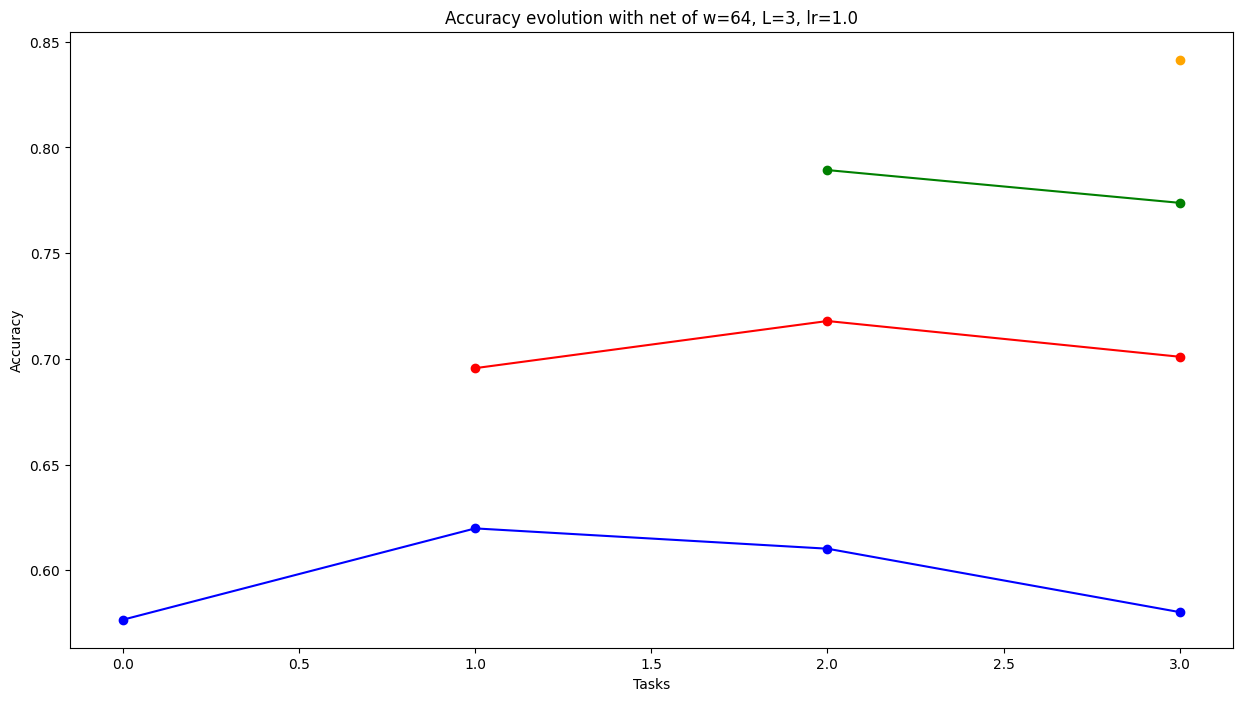

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                [-1, 1, 64]          50,176
              ReLU-2                [-1, 1, 64]               0
            Linear-3                [-1, 1, 64]           4,096
              ReLU-4                [-1, 1, 64]               0
            Linear-5                [-1, 1, 64]           4,096
              ReLU-6                [-1, 1, 64]               0
            Linear-7                [-1, 1, 64]           4,096
              ReLU-8                [-1, 1, 64]               0
            Linear-9                [-1, 1, 10]             640
Total params: 63,104
Trainable params: 63,104
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.24
Estimated Total Size (MB): 0.25
---------------------------------------------

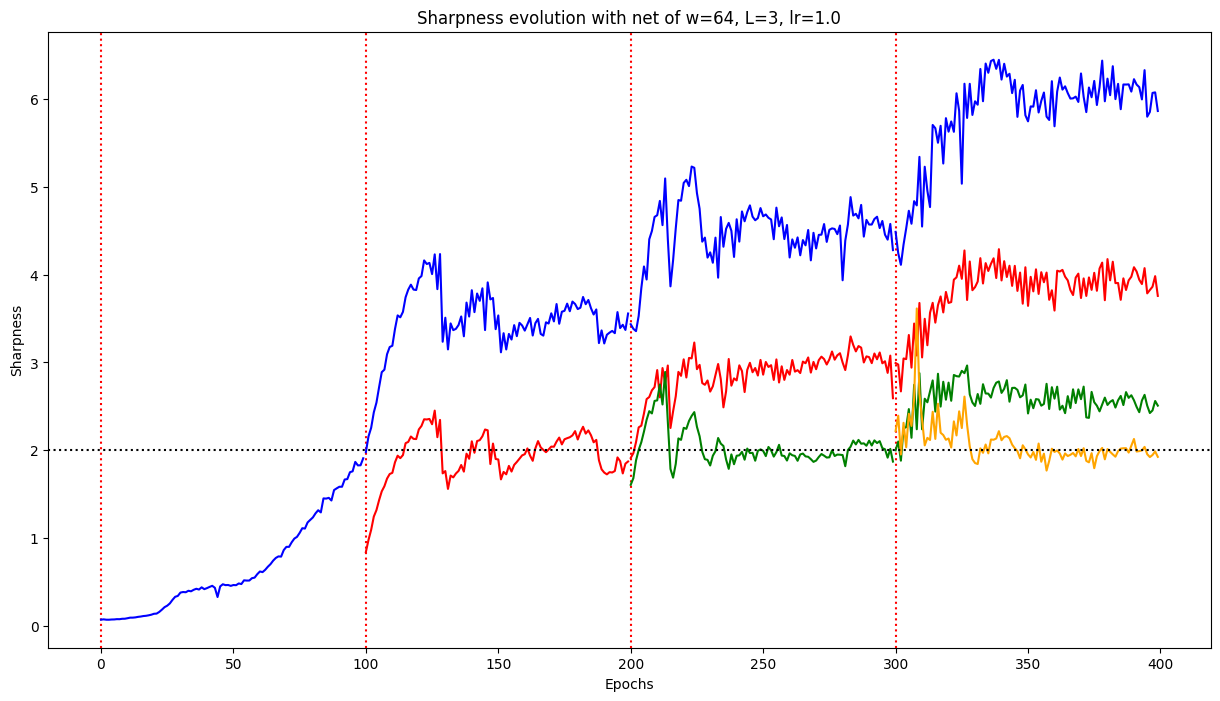

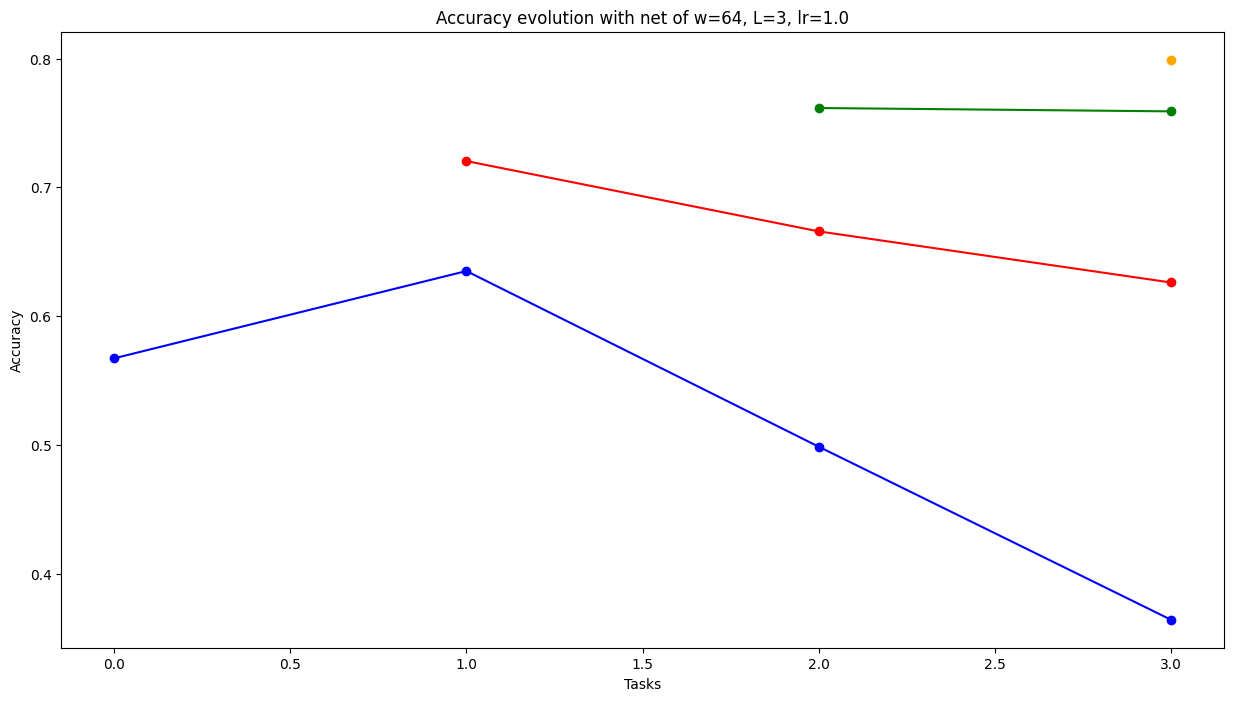

In [1]:
for eos in [1,2,3]:
        import torch
        import torch.nn as nn
        from pyhessian import hessian
        import pandas as pd
        import matplotlib.pyplot as plt
        import numpy as np
        from torchsummary import summary

        class MLP(nn.Module):
            """Standard MLP"""
            def __init__(self, w, L):
                super(MLP, self).__init__()
                self.w = w
                self.fc1 = nn.Linear(784, self.w, bias=False)
                self.layers = nn.ModuleList(nn.Linear(self.w,self.w, bias=False) for _ in range(L))
                self.fc2 = nn.Linear(self.w, 10, bias=False)
                self.relu = nn.ReLU()
                self.L = L

            def forward(self, x):
                x = self.relu(self.fc1(x))
                for l in self.layers:
                    x = self.relu(l(x))
                x = self.fc2(x)
                #x = x/np.sqrt(self.w*784)

                return x
            
        def permut_row(x, perm):
            return x[perm]

        epochs = 100
        n_tasks = 3
        N = 64
        eos = 2 
        L = 3
        loss_hist = []
        lam = []
        acc = []
        all = []
        device = 'mps'
        gen = torch.Generator(device=device)
        gen.manual_seed(123)

        # ---------------------- START DATA -------------------------
        data = pd.read_csv('~/data/MNIST/mnist_train.csv')
        test = pd.read_csv('~/data/MNIST/mnist_test.csv')
        #data = data[data['label'].isin([0, 1])]
        #test = test[test['label'].isin([0, 1])]
        X = torch.tensor(data.drop('label', axis = 1).to_numpy(), device=device)/255
        X_test = torch.tensor(test.drop('label', axis = 1).to_numpy(), device=device)/255

        Y_temp = torch.tensor(data['label'].to_numpy(), device=device)
        Y = torch.eye(10, device=device)[Y_temp]

        Y_temp = torch.tensor(test['label'].to_numpy(), device=device)
        Y_test = torch.eye(10, device=device)[Y_temp]

        tasks = [X]
        tasks_test = [X_test]

        for _ in range(n_tasks):
                perm = np.random.permutation(X.shape[1])
                tasks.append( torch.tensor(np.apply_along_axis(permut_row, axis = 1, arr=X.cpu(), perm=perm)).to(device) )
                tasks_test.append(torch.tensor(np.apply_along_axis(permut_row, axis = 1, arr=X_test.cpu(), perm=perm)).to(device))

        # ----------------------- END DATA -----------------------------

        mlp = MLP(N, L)
        summary(mlp, (1,784))
        mlp = mlp.to(device)

        optimizer = torch.optim.SGD(mlp.parameters(), lr=2/eos)

        def top_eigen(model, loss, X, Y, prt=False):

            hess_comp = hessian(model, loss, (X,Y) )
            top_eigenvalues, top_eigenvector = hess_comp.eigenvalues()
                
            return top_eigenvalues[-1] , top_eigenvector

        MSE = nn.MSELoss()

        s, _ = top_eigen(mlp, MSE , X, Y)

        def GSalign(model, eigen):
            z = 0
            for g,p in zip(model.parameters(), eigen[0]):
                    if g.requires_grad:
                        gd = g.grad
                        z += torch.sum(gd*p)/(torch.sqrt(torch.sum(gd*gd))*torch.sqrt(torch.sum(p*p))*len(eigen[0]))

            return z.item()

        batch = len(X)

        for t,Xt in enumerate(tasks):        
                for epoch in range(epochs):

                        running_loss = 0.0
                        for i in range(len(Xt)//batch):

                            # Batch of training 
                            ix = torch.randint(0, len(X), (batch,), generator=gen, device=device)

                            ixc = torch.randint(0, len(X), (1024,), generator=gen, device=device)

                            lt = []
                            for s in range(t+1):
                                sharp, eigen = top_eigen(mlp, MSE, tasks[s][ixc], Y[ixc])
                                lt.append(sharp)
                            lam.append(lt)    

                            optimizer.zero_grad()

                            out = mlp(Xt[ix])
                            loss = MSE(out, Y[ix])
                            loss.backward()
                            running_loss += loss.item()

                            #all.append(GSalign(mlp,eigen))

                            optimizer.step()
                            loss_hist.append(loss.item())
                            #print(f'task {t} : (epoch: {epoch}), sample: {batch*(i+1)}, ---> train loss = {loss.item():.4f}')

                print(f'Finished Training task{t}')
                
                acct = []
                for s in range(t+1):
                    acct.append( (torch.sum(torch.argmax(mlp(tasks_test[s]), dim=1) == torch.argmax(Y_test, dim=1))/len(Y_test)).item() )  
                acc.append(acct)  
                
        sharp0 = np.array(lam[0:epochs]).T
        sharp1 = np.array(lam[epochs:2*epochs]).T
        sharp2 = np.array(lam[2*epochs:3*epochs]).T
        sharp3 = np.array(lam[3*epochs:4*epochs]).T
        sharps = [sharp0,sharp1,sharp2,sharp3]

        colors = ['blue', 'red', 'green', 'orange']

        plt.figure(figsize=(15,8))
        plt.title(f'Sharpness evolution with net of w={N}, L={L}, lr={2/eos}')
        for i,s in enumerate(sharps):
            plt.axvline(i*epochs, color='r', linestyle='dotted')
            for j,row in enumerate(s):
                plt.plot(np.arange(i*epochs,(i+1)*epochs,1), row, color=colors[j] )

        plt.ylabel('Sharpness')
        plt.xlabel('Epochs')
        plt.axhline(eos, color='black', linestyle='dotted')
        plt.show()

        acc0 = np.array(acc[0])
        acc1 = np.array(acc[1])
        acc2 = np.array(acc[2])
        acc3 = np.array(acc[3])
        accs = [acc0,acc1,acc2,acc3]

        colors = ['blue', 'red', 'green', 'orange']

        plt.figure(figsize=(15,8))
        plt.title(f'Accuracy evolution with net of w={N}, L={L}, lr={2/eos}')
        for i in range(n_tasks):
                plt.plot(range(i,n_tasks+1),[a[i] for a in accs[i:]], color=colors[i], marker='o' )

        plt.plot(n_tasks,accs[-1][-1], color=colors[-1], marker='o')
        plt.ylabel('Accuracy')
        plt.xlabel('Tasks')
        plt.show()